In [1]:
#Not all these packages are required but they are here for completeness
import importlib
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops, ImageDraw
import SimpleITK as sitk
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_holes

In [2]:
# Import package 
BASE_DIR = Path().resolve()
HEMNET_DIR = BASE_DIR.parent.joinpath('HEMnet')

os.chdir(HEMNET_DIR)
from slide import *
from utils import *

In [3]:
# User Input parameters
SLIDES_PATH = Path('/gpfs1/scratch/90days/s4436005')
OUTPUT_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg/train_dataset_10x_02_12_19')

ALIGNMENT_MAG = 2
TILE_MAG = 10
VERBOSE = True

#Verbose functions
if VERBOSE:
    verbose_print = lambda *args: print(*args)
    verbose_save_img = lambda img, path, img_type: img.save(path, img_type)
    verbose_save_fig = lambda fig, path, dpi=300: fig.savefig(path, dpi=dpi)
else:
    verbose_print = lambda *args: None
    verbose_save_img = lambda *args: None
    verbose_save_fig = lambda *args: None

# Find Slides
slides = []
for slide in SLIDES_PATH.glob('*.svs'):
    name = slide.name
    slides.append(name)
slides.sort()
slides

['1820_N_10545A_2_HandE.svs',
 '1820_N_10545A_4_TP53.svs',
 '1820_T_105452F_2_HandE.svs',
 '1820_T_105452F_4_TP53.svs',
 '2065_N_12752A_2_HandE.svs',
 '2065_N_12752A_4_TP53.svs',
 '2065_T_12756A_2_HandE.svs',
 '2065_T_12756A_4_TP53.svs',
 '2112_N_12341B_2_HandE.svs',
 '2112_N_12341B_4_TP53.svs',
 '2112_T_12335F_2_HandE.svs',
 '2112_T_12335F_4_TP53.svs',
 '2148_N_11397A_2_HandE.svs',
 '2148_N_11397A_4_TP53.svs',
 '2148_T_11393A_2_HandE.svs',
 '2148_T_11393A_4_TP53.svs',
 '2171_N_11521A_2_HandE.svs',
 '2171_N_11521A_4_TP53.svs',
 '2171_T_11524A_2_HandE.svs',
 '2171_T_11524A_4_TP53.svs']

In [4]:
TP53_slides = [slide for slide in slides if 'TP53' in slide]
HE_slides = [slide for slide in slides if 'HandE' in slide]
Paired_slides = list(zip(TP53_slides, HE_slides))
Paired_slides

[('1820_N_10545A_4_TP53.svs', '1820_N_10545A_2_HandE.svs'),
 ('1820_T_105452F_4_TP53.svs', '1820_T_105452F_2_HandE.svs'),
 ('2065_N_12752A_4_TP53.svs', '2065_N_12752A_2_HandE.svs'),
 ('2065_T_12756A_4_TP53.svs', '2065_T_12756A_2_HandE.svs'),
 ('2112_N_12341B_4_TP53.svs', '2112_N_12341B_2_HandE.svs'),
 ('2112_T_12335F_4_TP53.svs', '2112_T_12335F_2_HandE.svs'),
 ('2148_N_11397A_4_TP53.svs', '2148_N_11397A_2_HandE.svs'),
 ('2148_T_11393A_4_TP53.svs', '2148_T_11393A_2_HandE.svs'),
 ('2171_N_11521A_4_TP53.svs', '2171_N_11521A_2_HandE.svs'),
 ('2171_T_11524A_4_TP53.svs', '2171_T_11524A_2_HandE.svs')]

In [1190]:
SLIDE_NUM = 7
PREFIX = Paired_slides[SLIDE_NUM][0][:-8]
verbose_print('Processing Slide: {0}'.format(PREFIX))
tp53_name, he_name = Paired_slides[SLIDE_NUM]
tp53_slide = open_slide(str(SLIDES_PATH.joinpath(tp53_name)))
he_slide = open_slide(str(SLIDES_PATH.joinpath(he_name)))

Processing Slide: 2148_T_11393A_4_


In [1191]:
def thumbnail(img, size = (1000,1000)):
    """Converts Pillow images to a different size without modifying the original image
    """
    img_thumbnail = img.copy()
    img_thumbnail.thumbnail(size)
    return img_thumbnail

In [1192]:
#Load Slides
he = read_slide_at_mag(he_slide, ALIGNMENT_MAG)
tp53 = read_slide_at_mag(tp53_slide, ALIGNMENT_MAG)

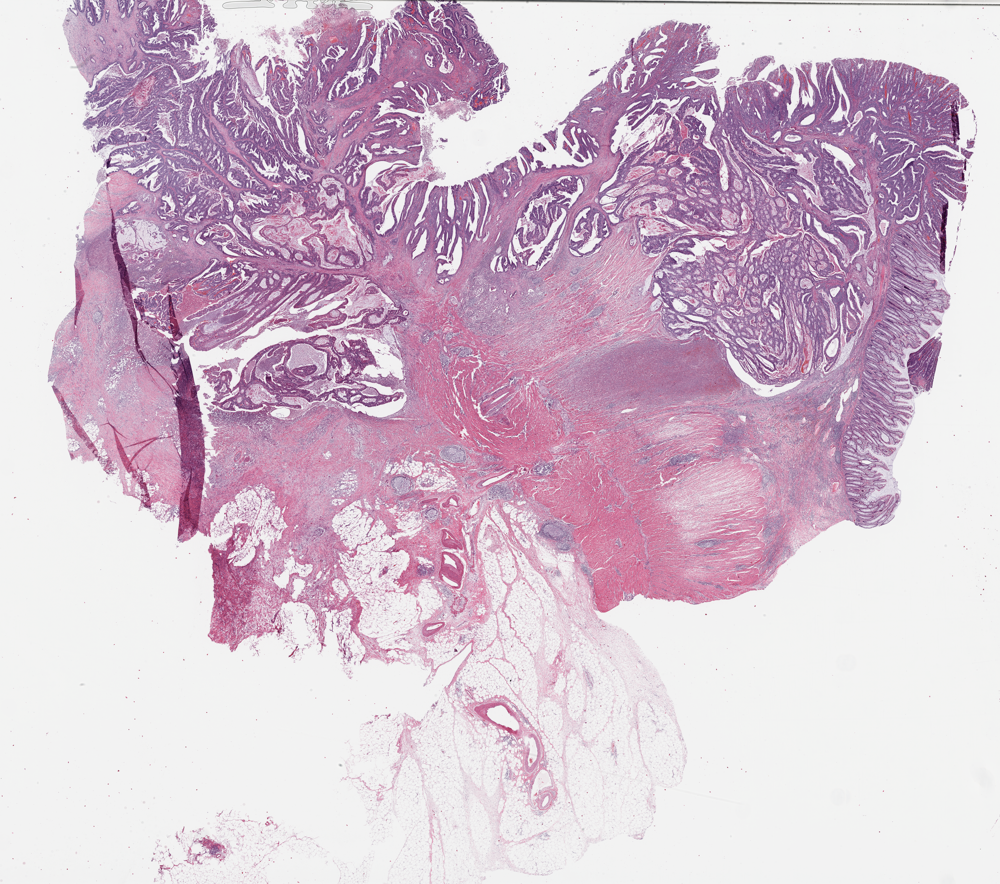

In [1193]:
thumbnail(he)

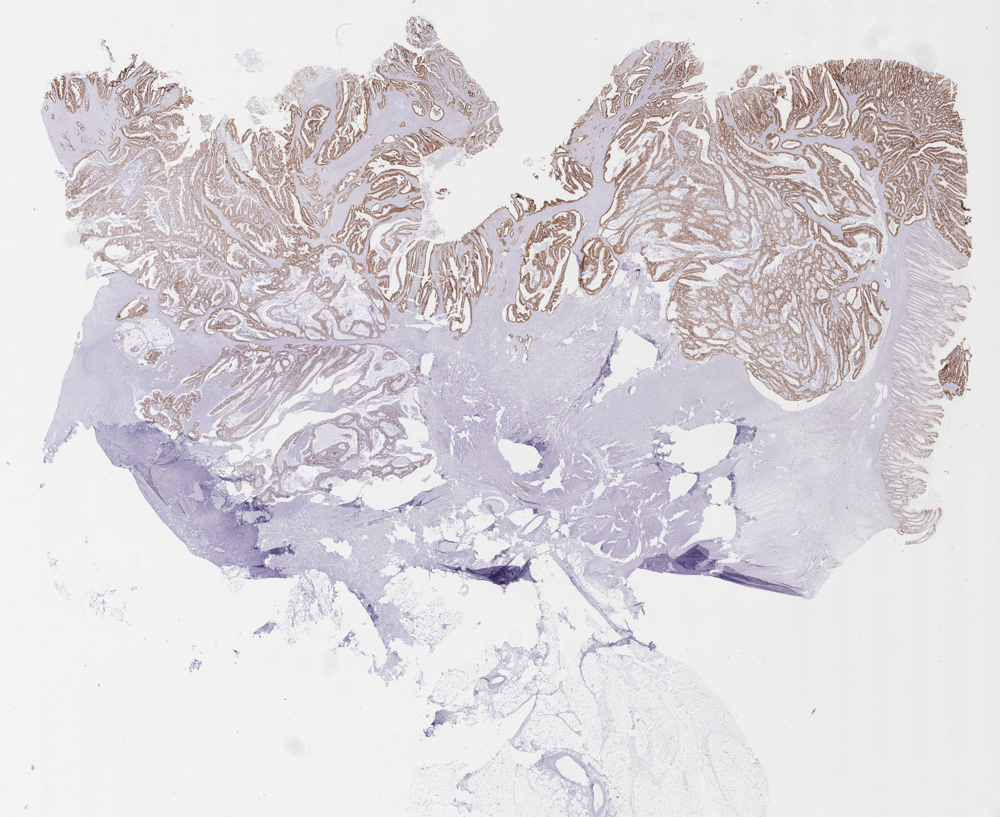

In [1194]:
thumbnail(tp53)

In [1195]:
#Remove backgrounds from TP53 and H&E images
tp53_filtered = filter_green(tp53)
he_filtered = filter_green(he)
tp53_filtered = filter_grays(tp53_filtered, tolerance = 3)
he_filtered = filter_grays(he_filtered, tolerance = 15)

In [1196]:
def show_mask(mask):
    return plt.imshow(np.reshape(mask, mask.shape[::-1]))

In [1197]:
tile_size = 299*ALIGNMENT_MAG/TILE_MAG

In [1198]:
hed_small = rgb2hed(thumbnail(tp53_filtered))
hed = rgb2hed(tp53_filtered)
dab_channel = -hed[:,:,2]
hem_channel = -hed[:,:,0]
hem_channel_small = -hed_small[:,:,0]
dab_channel_small = -hed_small[:,:,2]

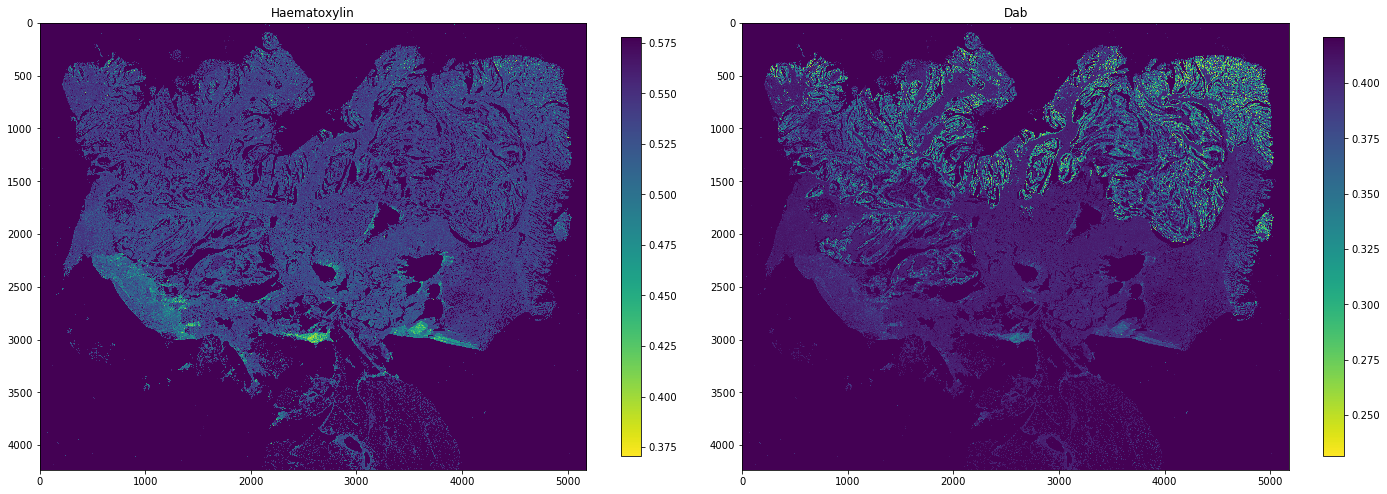

In [1199]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))
im1 = ax1.imshow(hem_channel, cmap = plt.cm.viridis_r)
ax1.set_title('Haematoxylin')
fig.colorbar(im1, shrink = 0.6, ax = ax1)
im2 = ax2.imshow(dab_channel, cmap = plt.cm.viridis_r)
fig.colorbar(im2, shrink = 0.6, ax = ax2)
ax2.set_title('Dab')
plt.tight_layout()

# Implementation A

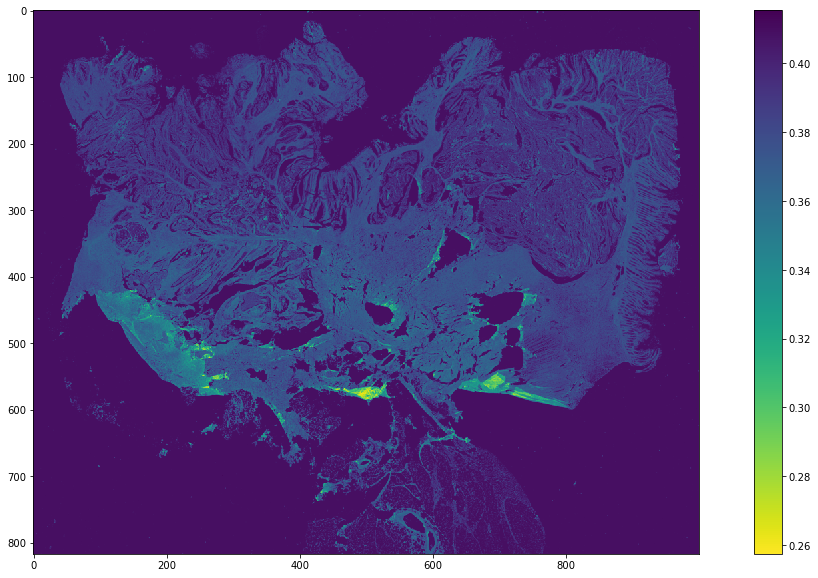

In [1200]:
hem_channel_adjusted = hem_channel - 0.4*dab_channel
hem_channel_adjusted_small = hem_channel_small - 0.4*dab_channel_small
fig, ax = plt.subplots(figsize = (20,10))
im1 = ax.imshow(hem_channel_adjusted_small, cmap = plt.cm.viridis_r)
fig.colorbar(im1, ax = ax)

In [1201]:
hem_thresh = threshold_otsu(hem_channel_adjusted_small)
print(hem_thresh)

0.3910697435912419


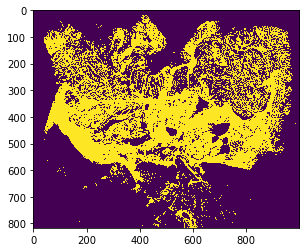

In [1202]:
plt.imshow(hem_channel_adjusted_small < hem_thresh)

In [1203]:
hem_masked = np.array([x for x in hem_channel_adjusted_small.ravel() if x < hem_thresh])

In [1204]:
#Otsu Thresholding
hist, bin_centers = histogram(hem_masked, 256)
hist = hist.astype(float)
# class probabilities for all possible thresholds
weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]
# class means for all possible thresholds
mean1 = np.cumsum(hist * bin_centers) / weight1
mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]
# Clip ends to align class 1 and class 2 variables:
# The last value of `weight1`/`mean1` should pair with zero values in
# `weight2`/`mean2`, which do not exist.
variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
idx = np.argmax(variance12)
#Consider all cells are normal if variance is too small
if variance12[idx] < 5000000:
    threshold = 0
else:
    threshold = bin_centers[:-1][idx]

In [1205]:
threshold

0.3657620074853085

In [1206]:
variance12[idx]

7535527.241762294

Variances

0. 2273236.53996798
1. 698008.7107217973
2. 947748.8442116535
3. 1909672.8238292371
4. 937957.1777300985
5. 1856733.398941235
6. 5923701.446552224
7. 7535527.241762294
8. 1798110.5427150154
9. 890731.1982803243

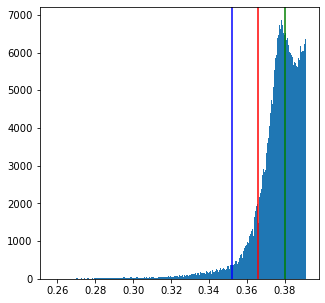

In [1207]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(hem_masked.ravel(), bins = 256)
ax.axvline(threshold, color='r')
ax.axvline(mean1[idx], color = 'b')
ax.axvline(mean2[idx], color = 'g')
plt.show()

In [1208]:
fold_binary = np.invert(hem_channel_adjusted < threshold)
fold_binary_filtered = remove_small_holes(fold_binary, area_threshold = 4096)

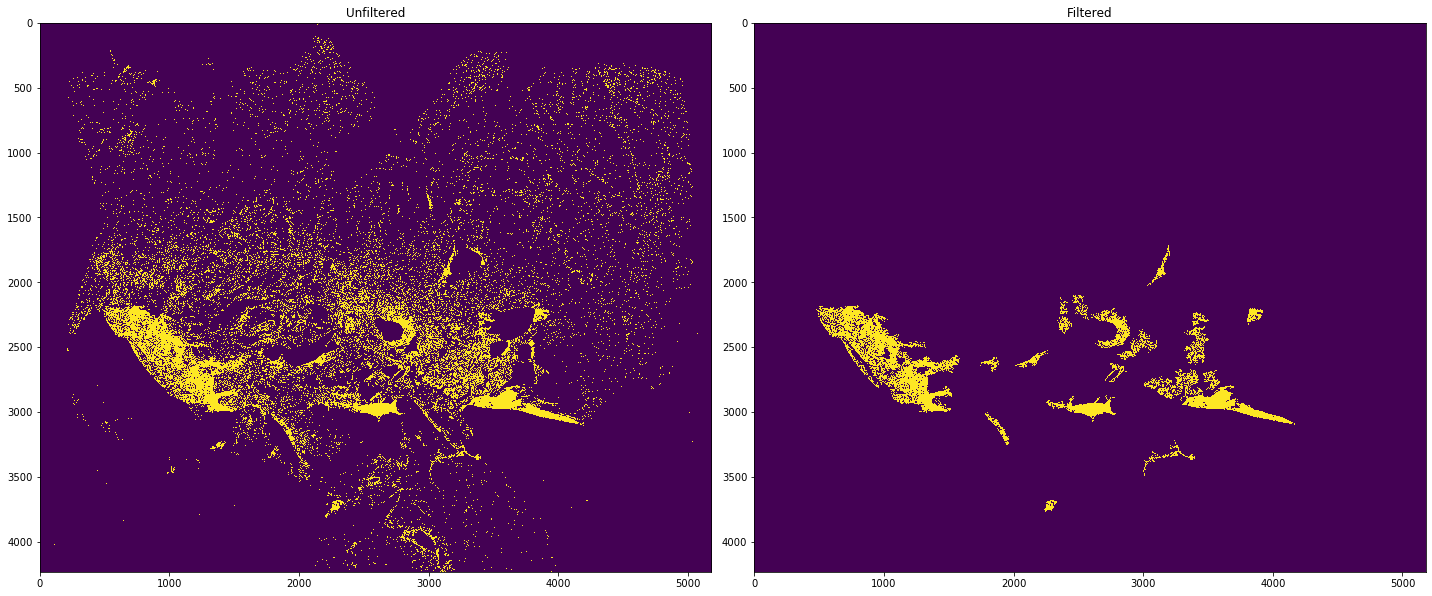

In [1209]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))
ax1.imshow(fold_binary, cmap = plt.cm.viridis_r)
ax1.set_title('Unfiltered')
ax2.imshow(fold_binary_filtered, cmap = plt.cm.viridis_r)
ax2.set_title('Filtered')
plt.tight_layout()

In [1210]:
tgen = tile_gen(binary2gray(fold_binary_filtered), tile_size)
fold_mask = threshold_mask(tgen, 250)

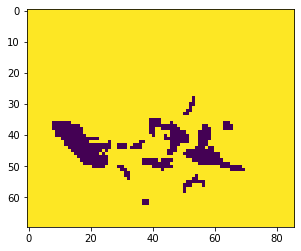

In [1211]:
show_mask(fold_mask)

In [1212]:
overlay = plot_mask(tp53_filtered, fold_mask, tile_size)

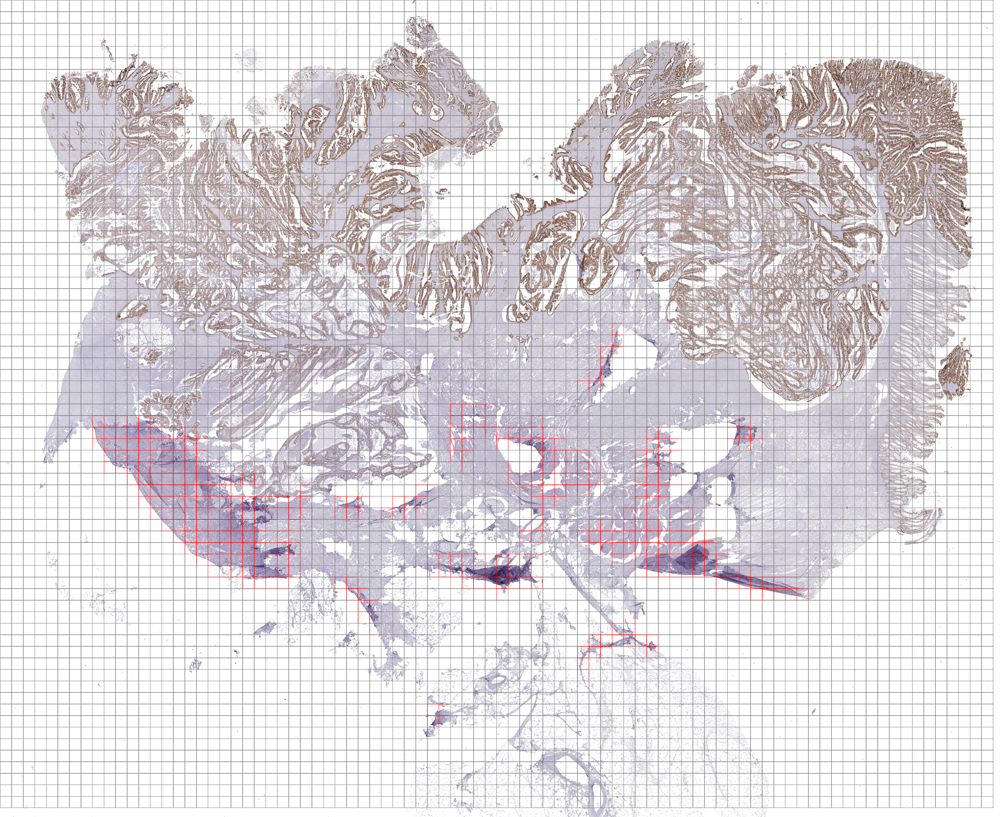

In [1213]:
thumbnail(overlay)

In [1214]:
def folded_tissue_mask(img, tile_size):
    hed_small = rgb2hed(thumbnail(img, (1000,1000)))
    hed = rgb2hed(img)
    dab_channel = -hed[:,:,2]
    hem_channel = -hed[:,:,0]
    hem_channel_small = -hed_small[:,:,0]
    dab_channel_small = -hed_small[:,:,2]
    hem_channel_adjusted = hem_channel - 0.4*dab_channel
    hem_channel_adjusted_small = hem_channel_small - 0.4*dab_channel_small
    hem_thresh = threshold_otsu(hem_channel_adjusted_small)
    hem_masked = np.array([x for x in hem_channel_adjusted_small.ravel() if x < hem_thresh])
    #Otsu Thresholding
    hist, bin_centers = histogram(hem_masked, 256)
    hist = hist.astype(float)
    # class probabilities for all possible thresholds
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    # class means for all possible thresholds
    mean1 = np.cumsum(hist * bin_centers) / weight1
    mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]
    # Clip ends to align class 1 and class 2 variables:
    # The last value of `weight1`/`mean1` should pair with zero values in
    # `weight2`/`mean2`, which do not exist.
    variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    idx = np.argmax(variance12)
    #Consider all cells are normal if variance is too small
    if variance12[idx] < 5000000:
        threshold = 0
    else:
        threshold = bin_centers[:-1][idx]
    fold_binary = np.invert(hem_channel_adjusted < threshold)
    fold_binary_filtered = remove_small_holes(fold_binary, area_threshold = 4096)
    tgen = tile_gen(binary2gray(fold_binary_filtered), tile_size)
    fold_mask = threshold_mask(tgen, 250)
    return fold_mask

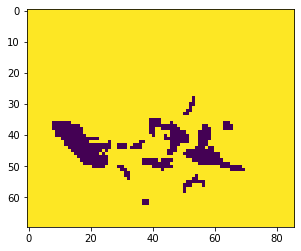

In [1215]:
show_mask(folded_tissue_mask(tp53_filtered, tile_size))

# Implementation B

In [1236]:
hem_thresh = threshold_otsu(hem_channel_small)
print(hem_thresh)

0.5541935457100589


In [1237]:
dab_thresh = threshold_otsu_masked(hed_small)
print(dab_thresh)

0.37494322843028566


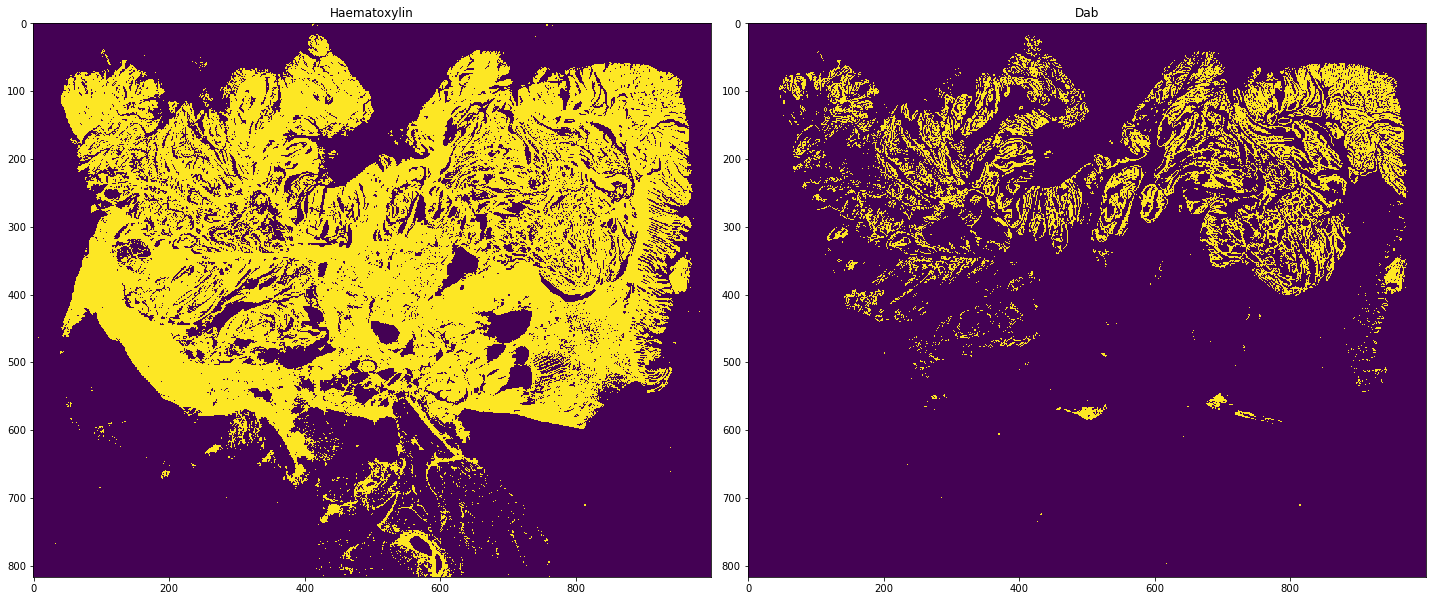

In [1238]:
hem_binary_otsu = hem_channel_small > hem_thresh
dab_binary_otsu = dab_channel_small > dab_thresh
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))
im1 = ax1.imshow(hem_binary_otsu, cmap = plt.cm.viridis_r)
ax1.set_title('Haematoxylin')
im2 = ax2.imshow(dab_binary_otsu, cmap = plt.cm.viridis_r)
ax2.set_title('Dab')
plt.tight_layout()

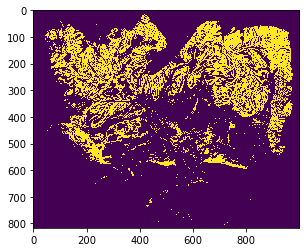

In [1239]:
plt.imshow(dab_channel_small < 0.4 )

In [1240]:
hed.shape

(4234, 5179, 3)

In [1241]:
hed[0][0]

array([-0.57739655,  0.16859676, -0.42079731])

In [1242]:
#Convert hed image into array of pixel [h,e,d] values
hed_pixels = -hed_small.flatten().reshape(hed_small.shape[0]*hed_small.shape[1], 3)

In [1243]:
#Only select pixels that are not background or are positively stained
hem_masked = np.array([h for h,e,d in hed_pixels if h < hem_thresh and d < dab_thresh ])

In [1244]:
hem_masked
#TODO: Check that hem_masked is not empty

array([0.51962891, 0.51662537, 0.53405897, ..., 0.43947016, 0.42714087,
       0.49785054])

In [1245]:
#Otsu Thresholding
hist, bin_centers = histogram(hem_masked, 256)
hist = hist.astype(float)
# class probabilities for all possible thresholds
weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]
# class means for all possible thresholds
mean1 = np.cumsum(hist * bin_centers) / weight1
mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]
# Clip ends to align class 1 and class 2 variables:
# The last value of `weight1`/`mean1` should pair with zero values in
# `weight2`/`mean2`, which do not exist.
variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
idx = np.argmax(variance12)
#Consider all cells are normal if variance is too small
if variance12[idx] < 50000:
    threshold = 0
else:
    threshold = bin_centers[:-1][idx]

In [1246]:
mean1[idx]

0.444667354173437

In [1247]:
mean2[idx]

0.5299317181373705

In [1248]:
variance12[idx]

886109.2778844979

*Variances*
0. 4731.322417514922
1. 19579.47624109191
2. 53928.14902769623
3. 1745756.4323586498
4. NaN
5. 189675.37006784262
6. 510101.32491345174
7. 886109.2778844979
8. 145689.8423625998
9. 322804.611097460

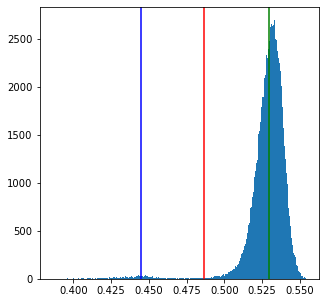

In [1249]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(hem_masked.ravel(), bins = 256)
ax.axvline(threshold, color='r')
ax.axvline(mean1[idx], color = 'b')
ax.axvline(mean2[idx], color = 'g')
plt.show()

In [1250]:
fold_binary = np.invert(hem_channel < threshold)
fold_binary_filtered = remove_small_holes(fold_binary, area_threshold = 256)

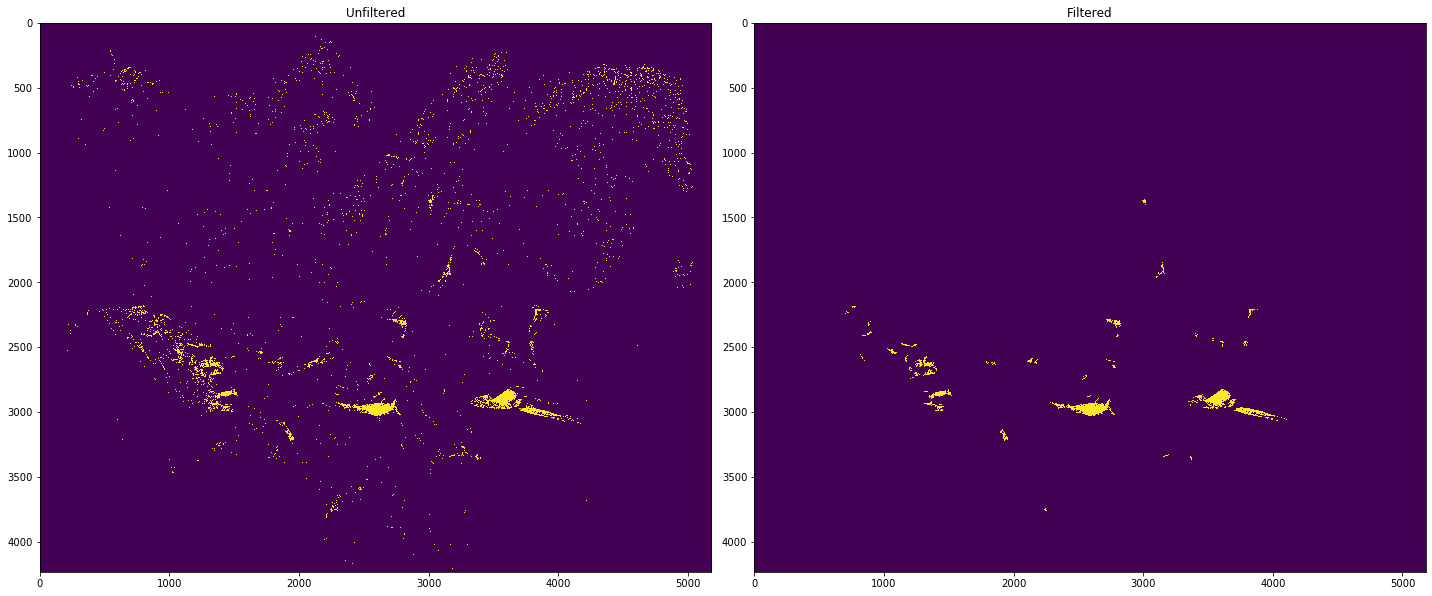

In [1251]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))
ax1.imshow(fold_binary, cmap = plt.cm.viridis_r)
ax1.set_title('Unfiltered')
ax2.imshow(fold_binary_filtered, cmap = plt.cm.viridis_r)
ax2.set_title('Filtered')
plt.tight_layout()

In [1252]:
tgen = tile_gen(binary2gray(fold_binary_filtered), tile_size)
fold_mask = threshold_mask(tgen, 250)

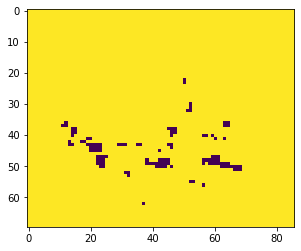

In [1253]:
show_mask(fold_mask)

In [1254]:
overlay = plot_mask(tp53_filtered, fold_mask, tile_size)

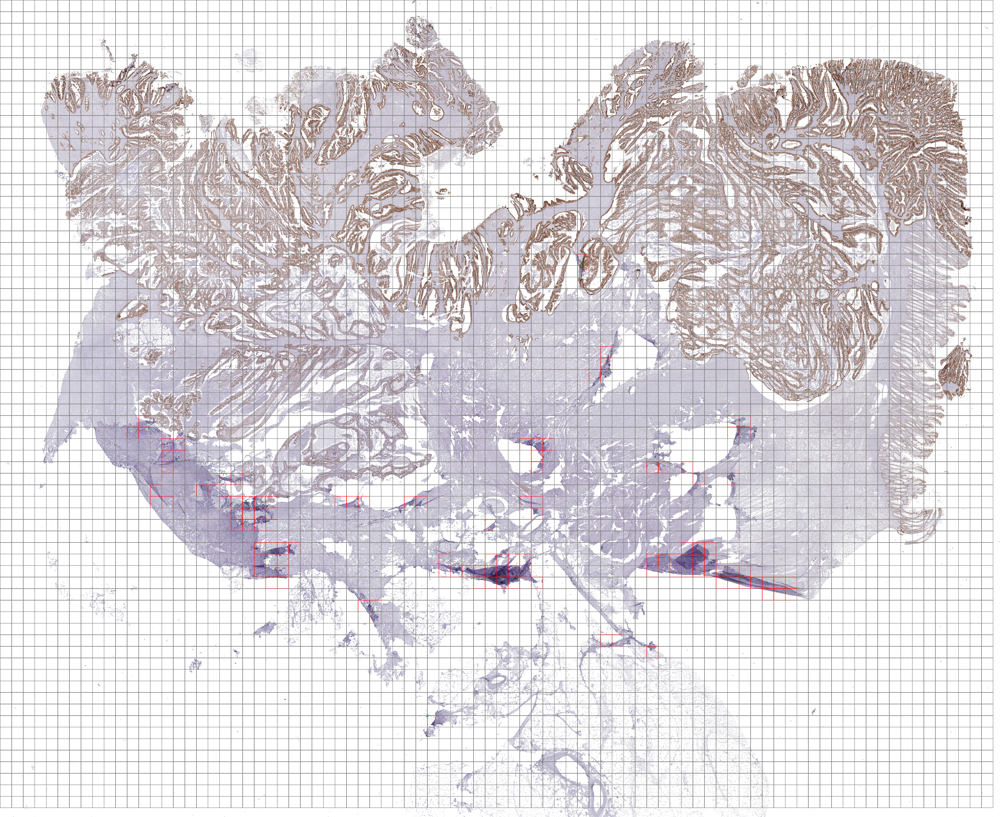

In [1255]:
thumbnail(overlay)